In [ ]:
%pip install catboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib, json, os
import seaborn as sns
sns.set()


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge, Lasso

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

### **1. Loading Data**

In [ ]:
df = pd.read_csv('laptop_data.csv')

In [ ]:
df.head()

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,msoffice,Price,rating,Number of Ratings,Number of Reviews
0,ASUS,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,34649,2 stars,3,0
1,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,38999,3 stars,65,5
2,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,39999,3 stars,8,1
3,ASUS,Intel,Core i5,10th,8 GB,DDR4,512 GB,0 GB,Windows,32-bit,2 GB,Casual,No warranty,No,No,69990,3 stars,0,0
4,ASUS,Intel,Celeron Dual,Not Available,4 GB,DDR4,0 GB,512 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,26990,3 stars,0,0


In [ ]:
print(df.shape)

(823, 19)


### **2. Data Checks**
- Checking missing values
- Checking duplicates
- Checking data types of each column
- Checking the number of unique values of each column
- Checking statistics of data set
- Checking various categories present in different categorical column

In [ ]:
df.isna().sum()

,0
brand,0
processor_brand,0
processor_name,0
processor_gnrtn,0
ram_gb,0
ram_type,0
ssd,0
hdd,0
os,0
os_bit,0


In [ ]:
df.duplicated().sum()

np.int64(21)

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 802 entries, 0 to 822
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   brand              802 non-null    object
 1   processor_brand    802 non-null    object
 2   processor_name     802 non-null    object
 3   processor_gnrtn    802 non-null    object
 4   ram_gb             802 non-null    object
 5   ram_type           802 non-null    object
 6   ssd                802 non-null    object
 7   hdd                802 non-null    object
 8   os                 802 non-null    object
 9   os_bit             802 non-null    object
 10  graphic_card_gb    802 non-null    object
 11  weight             802 non-null    object
 12  warranty           802 non-null    object
 13  Touchscreen        802 non-null    object
 14  msoffice           802 non-null    object
 15  Price              802 non-null    int64 
 16  rating             802 non-null    object
 17  Nu

In [ ]:
df.nunique()

,0
brand,8
processor_brand,3
processor_name,11
processor_gnrtn,8
ram_gb,4
ram_type,6
ssd,7
hdd,4
os,3
os_bit,2


In [ ]:
df.describe()

,Price,Number of Ratings,Number of Reviews
count,802.000000,802.00000,802.000000
mean,76625.543641,299.84414,36.089776
std,45232.984422,1001.78442,118.313553
min,16990.000000,0.00000,0.000000
25%,45990.000000,0.00000,0.000000
50%,63990.000000,17.00000,2.000000
75%,89525.000000,140.25000,18.000000
max,441990.000000,15279.00000,1947.000000


#### **Insights**
- There are some outliers in all the 3 numerical columns
- No missing values in the dataset

In [ ]:
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'object']
cat_features = [feature for feature in df.columns if df[feature].dtype == 'object']
print("Numerical features: ", numeric_features)
print("Categorical featues:", cat_features)

Numerical features:  ['Price', 'Number of Ratings', 'Number of Reviews']
Categorical featues: ['brand', 'processor_brand', 'processor_name', 'processor_gnrtn', 'ram_gb', 'ram_type', 'ssd', 'hdd', 'os', 'os_bit', 'graphic_card_gb', 'weight', 'warranty', 'Touchscreen', 'msoffice', 'rating']


### **3. Data Visualization**

#### 3.1 Histograms

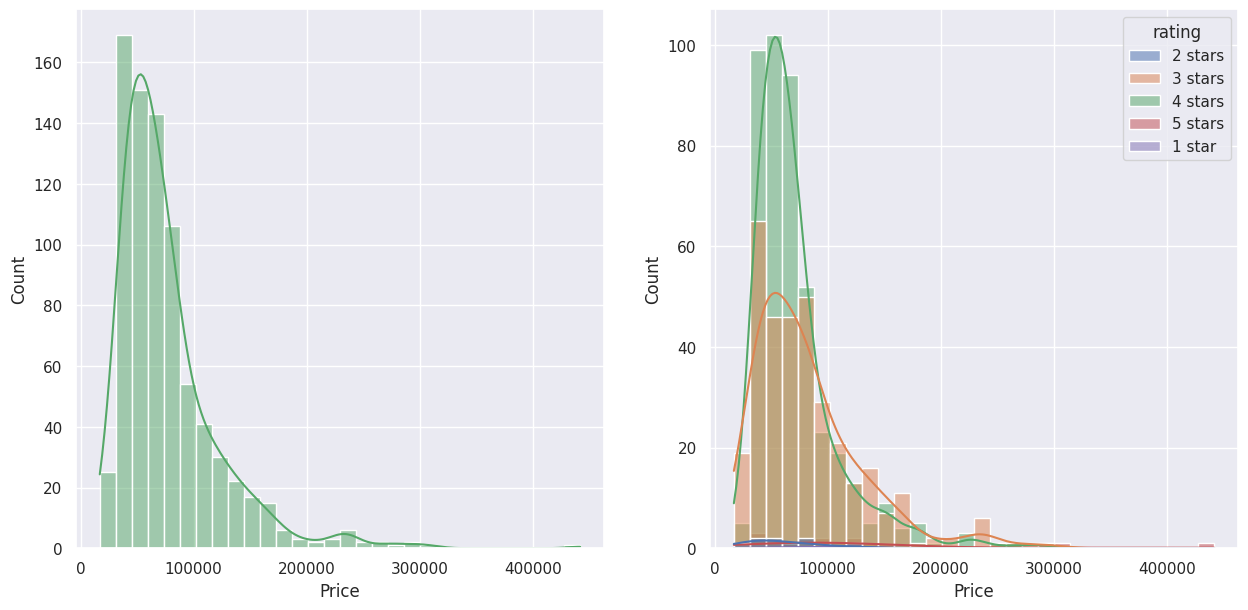

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
plt.subplot(121)
sns.histplot(data=df, x= 'Price', bins=30, kde=True, color='g')
plt.subplot(122)
sns.histplot(data=df, x= 'Price', bins=30, kde=True, color='g', hue= 'rating')
plt.show()

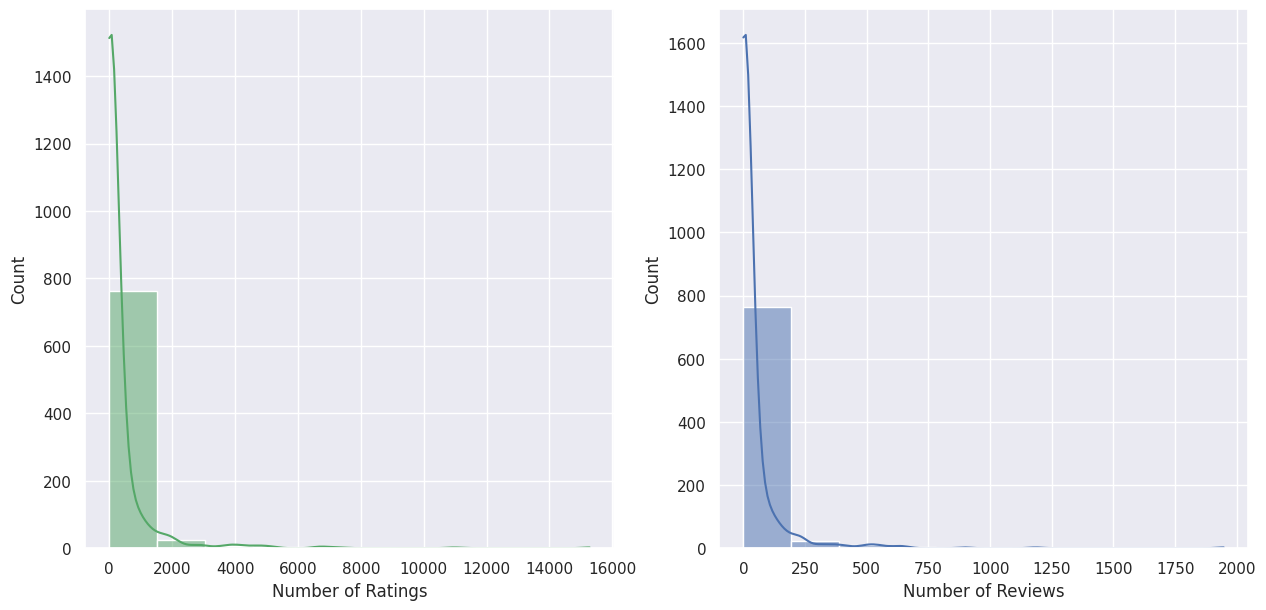

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
plt.subplot(121)
sns.histplot(data=df,x='Number of Ratings',bins=10,kde=True,color='g')
plt.subplot(122)
sns.histplot(data=df,x='Number of Reviews',kde=True, bins = 10)
plt.show()

In [ ]:
def remove_outliers(df, column):
    percentile25 = df[column].quantile(0.25)
    percentile75 = df[column].quantile(0.75)
    iqr = percentile75-percentile25
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    df = df[(df[column] < upper_limit) & (df[column] > lower_limit)]
    return df


In [ ]:
df = remove_outliers(df, 'Price')
df = remove_outliers(df, 'Number of Ratings')
df = remove_outliers(df, 'Number of Reviews')

#### 3.2 Pie Charts

#### 3.3 Multivariate Analysis

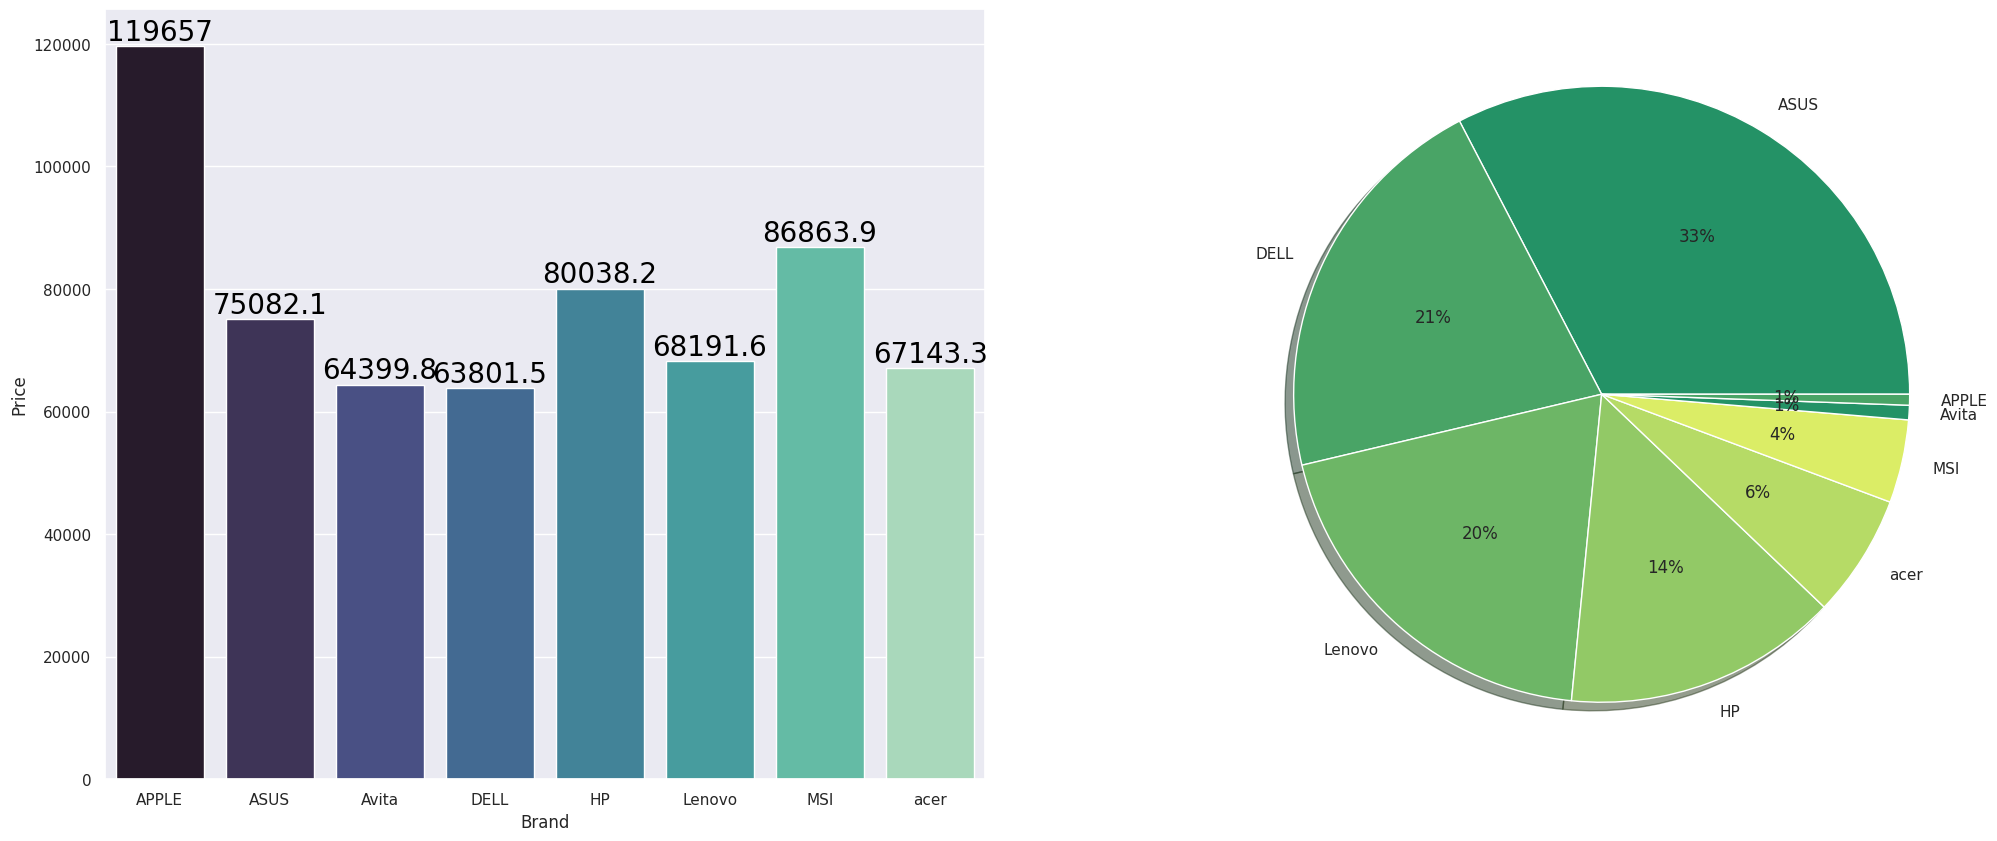

In [ ]:
f,ax=plt.subplots(1,2,figsize=(25,10))
Group_data = df.groupby('brand')
sns.barplot(x = Group_data ['Price'].mean().index, y = Group_data['Price'].mean().values,ax= ax[0],  palette = 'mako')
for container in ax[0].containers:
    ax[0].bar_label(container,color='black',size=20)
    ax[0].set_xlabel("Brand")
    ax[0].set_ylabel("Price")

palette_color = sns.color_palette('summer')
plt.pie(x = df['brand'].value_counts(),labels=df['brand'].value_counts().index,autopct='%.0f%%',shadow=True, colors= palette_color)
plt.show()

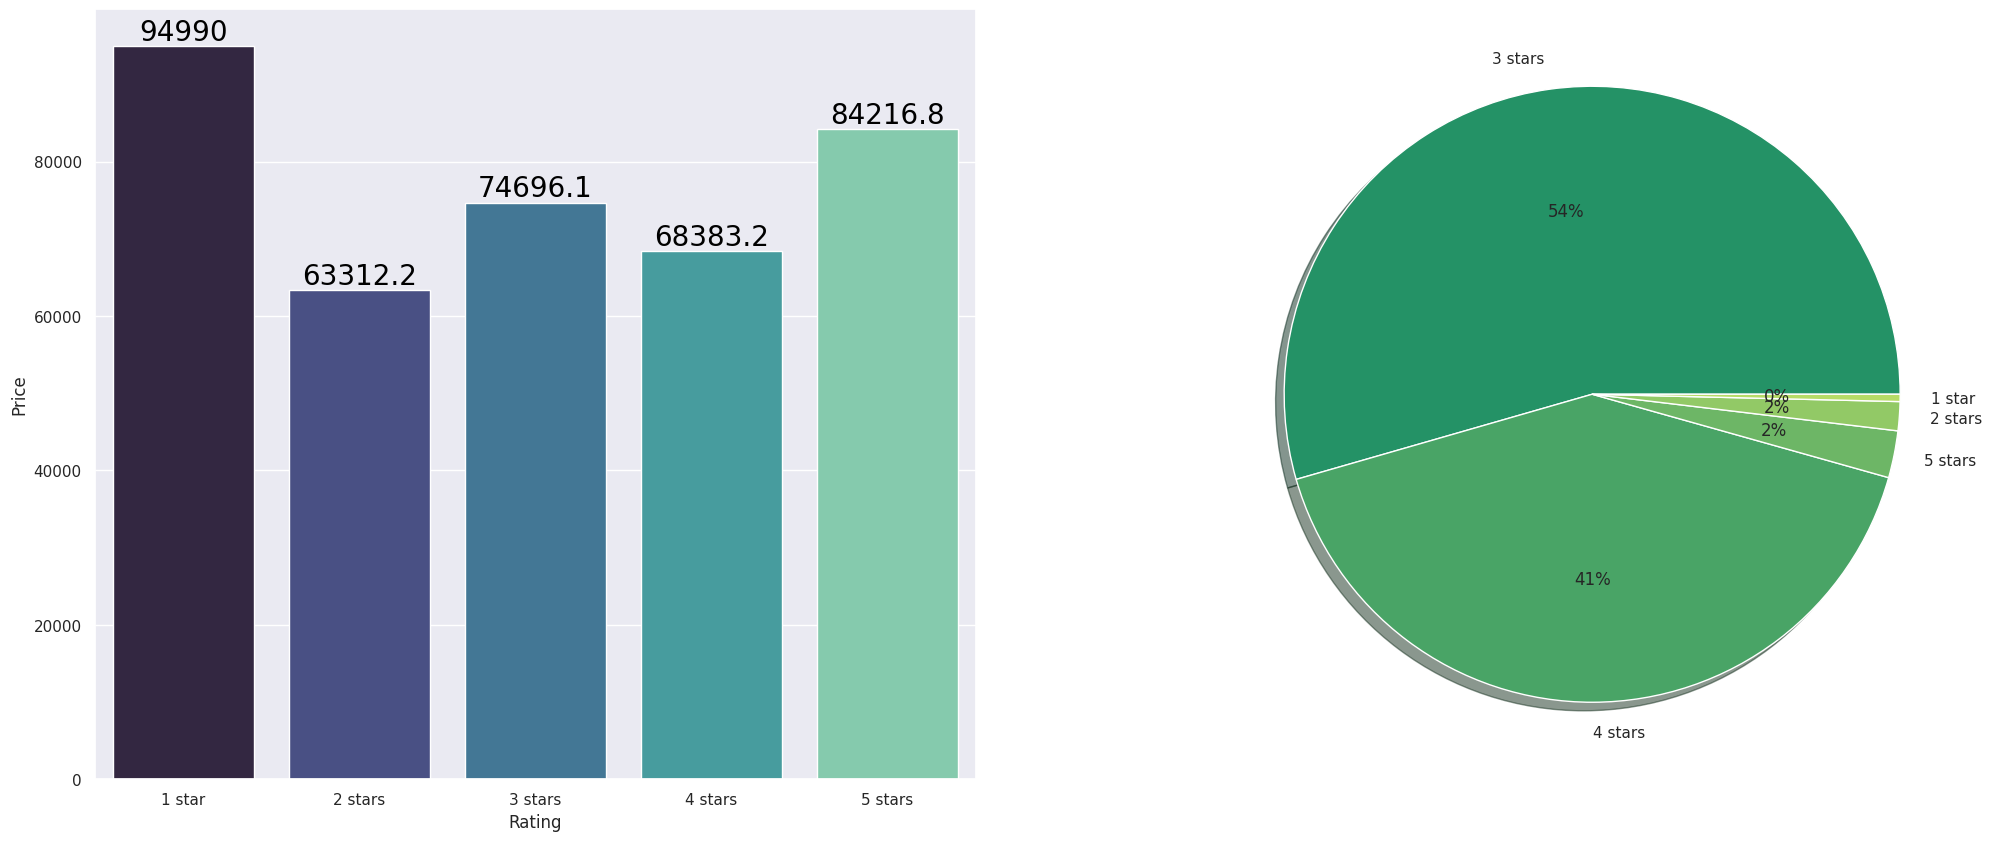

In [ ]:
f,ax=plt.subplots(1,2,figsize=(25,10))
Group_data = df.groupby('rating')
sns.barplot(x = Group_data ['Price'].mean().index, y = Group_data['Price'].mean().values,ax= ax[0],  palette = 'mako')
for container in ax[0].containers:
    ax[0].bar_label(container,color='black',size=20)
    ax[0].set_xlabel("Rating")
    ax[0].set_ylabel("Price")

palette_color = sns.color_palette('summer')
plt.pie(x = df['rating'].value_counts(),labels=df['rating'].value_counts().index,autopct='%.0f%%',shadow=True, colors= palette_color)
plt.show()

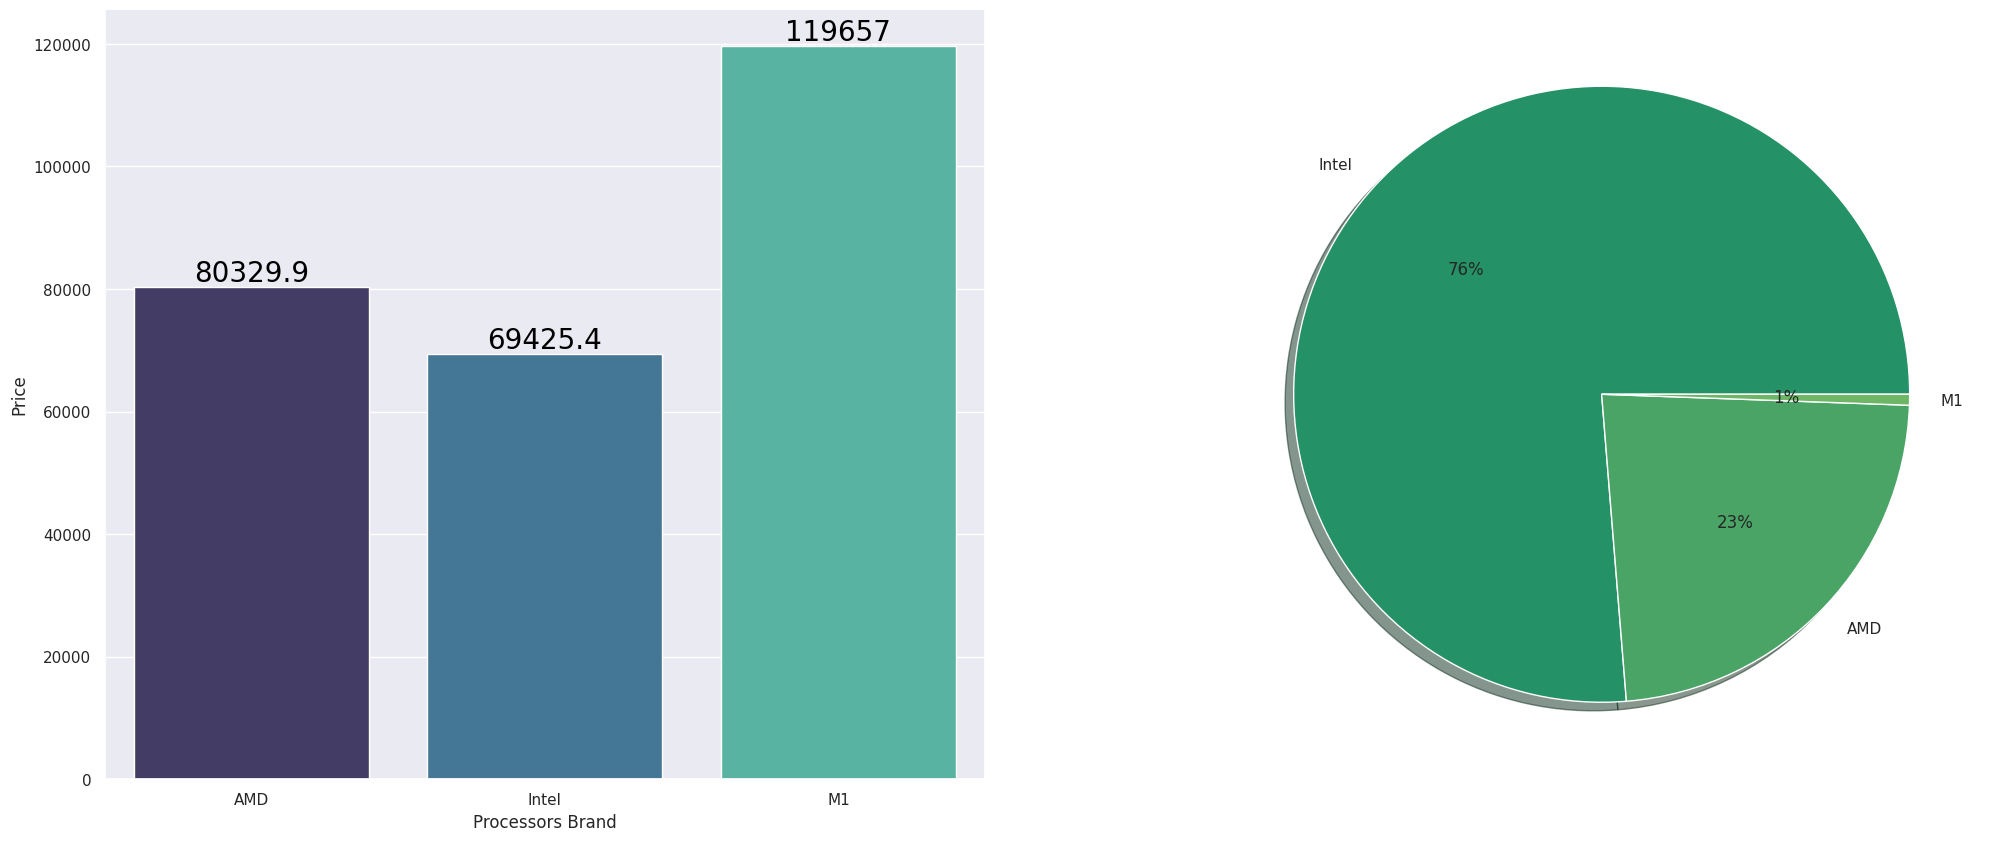

In [ ]:
f,ax=plt.subplots(1,2,figsize=(25,10))
Group_data = df.groupby('processor_brand')
sns.barplot(x = Group_data ['Price'].mean().index, y = Group_data['Price'].mean().values,ax= ax[0],  palette = 'mako')
for container in ax[0].containers:
    ax[0].bar_label(container,color='black',size=20)
    ax[0].set_xlabel("Processors Brand")
    ax[0].set_ylabel("Price")

palette_color = sns.color_palette('summer')
plt.pie(x = df['processor_brand'].value_counts(),labels=df['processor_brand'].value_counts().index,autopct='%.0f%%',shadow=True, colors= palette_color)
plt.show()

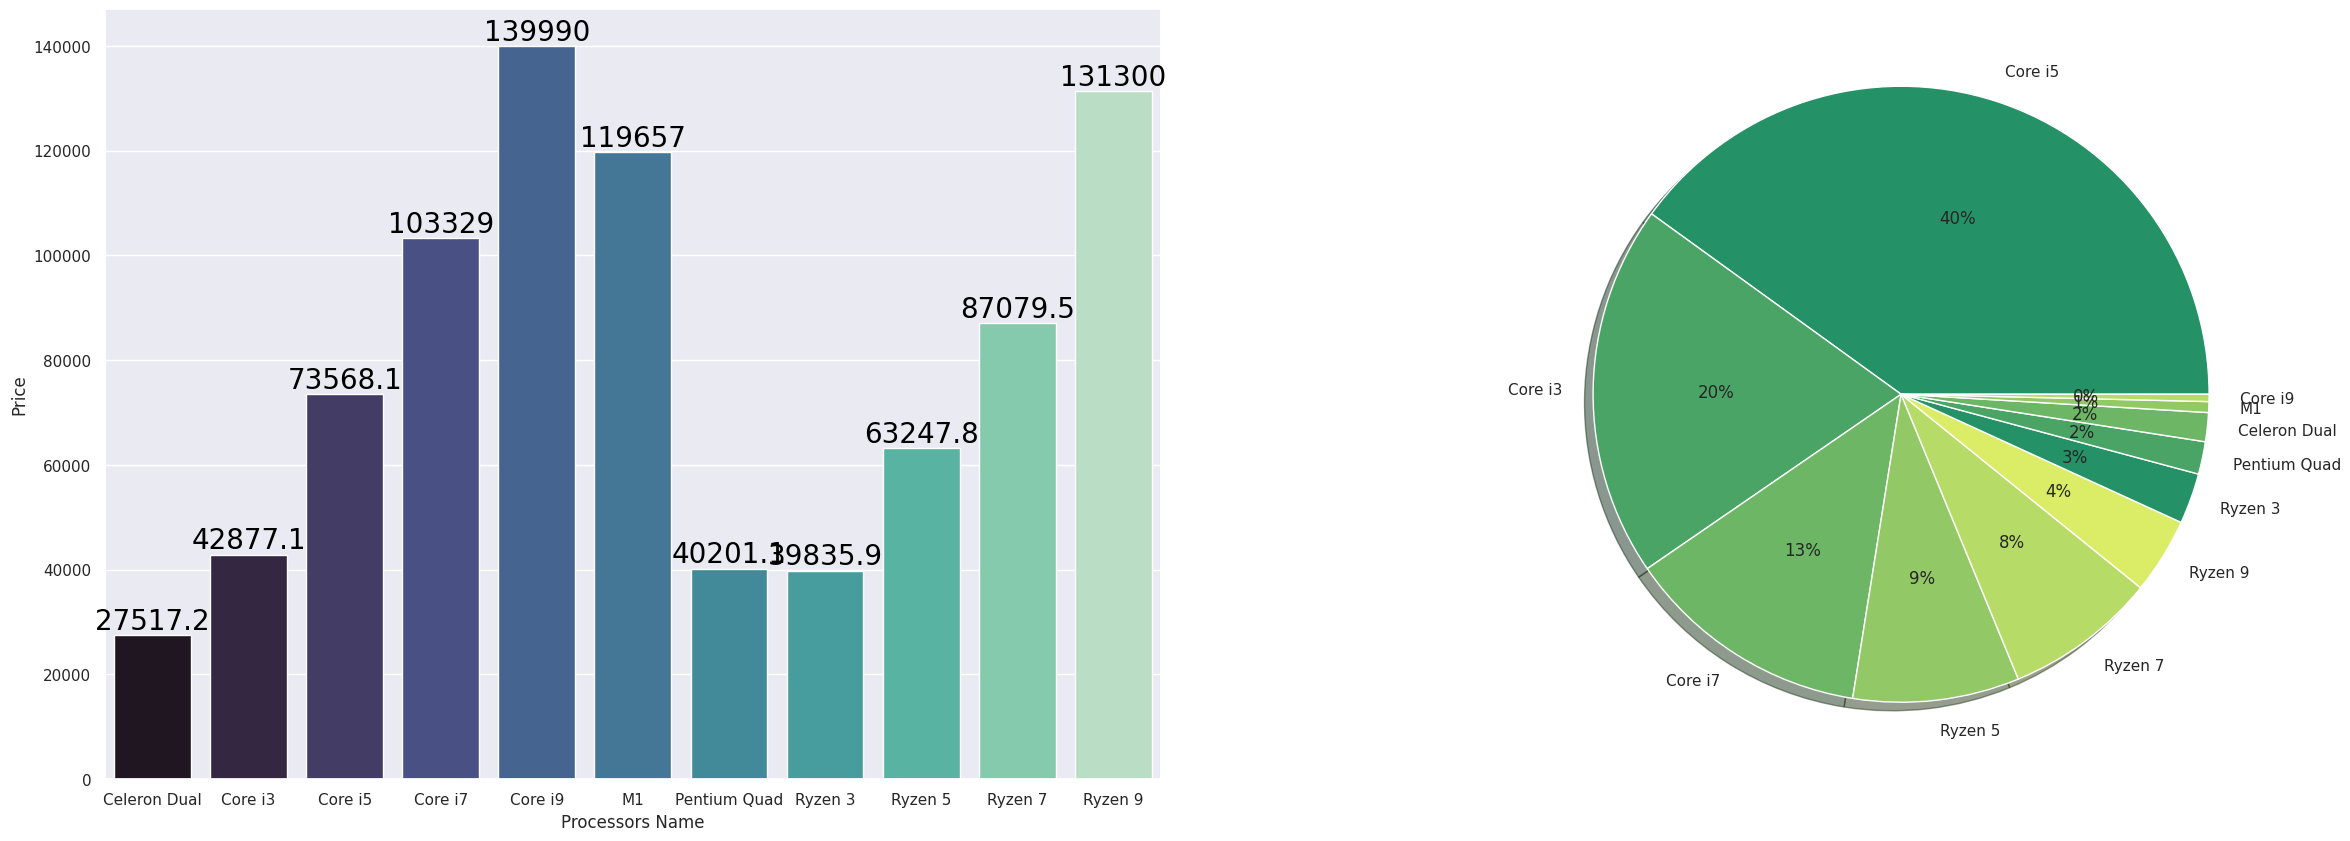

In [ ]:
f,ax=plt.subplots(1,2,figsize=(30,10))
Group_data = df.groupby('processor_name')
sns.barplot(x = Group_data ['Price'].mean().index, y = Group_data['Price'].mean().values,ax= ax[0],  palette = 'mako')
for container in ax[0].containers:
    ax[0].bar_label(container,color='black',size=20)
    ax[0].set_xlabel("Processors Name")
    ax[0].set_ylabel("Price")
palette_color = sns.color_palette('summer')
plt.pie(x = df['processor_name'].value_counts(),labels=df['processor_name'].value_counts().index,autopct='%.0f%%',shadow=True, colors= palette_color)
plt.show()

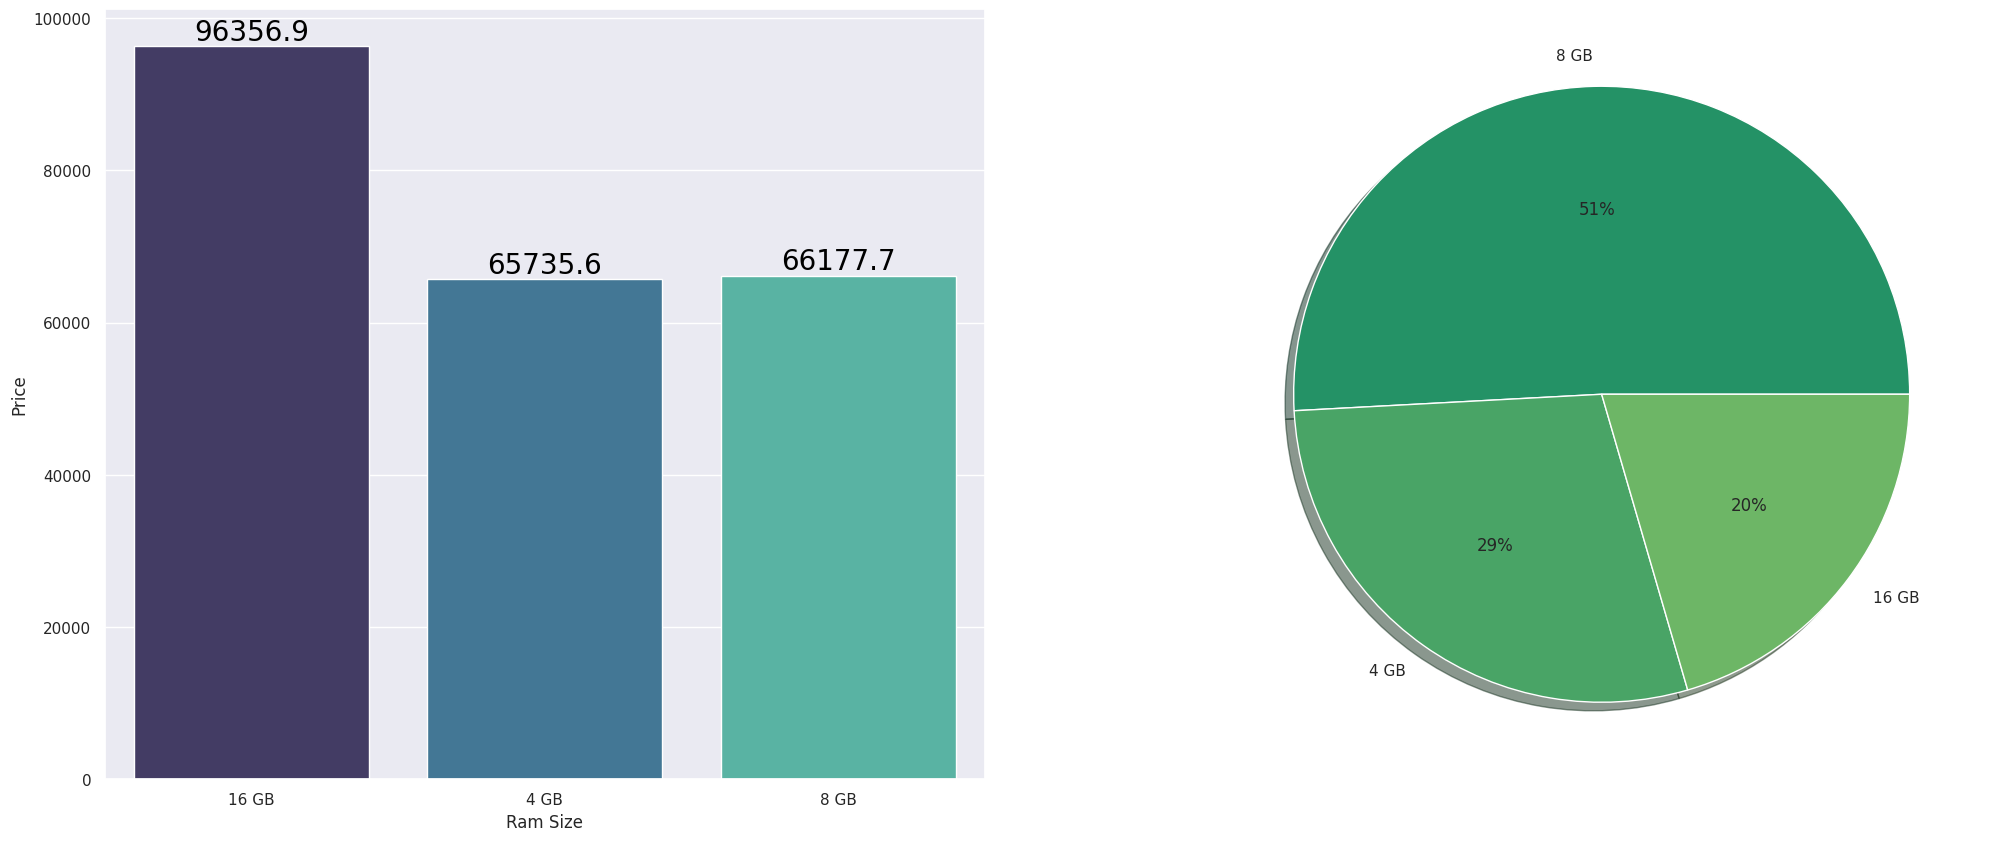

In [ ]:
f,ax=plt.subplots(1,2,figsize=(25,10))
Group_data = df.groupby('ram_gb')
sns.barplot(x = Group_data ['Price'].mean().index, y = Group_data['Price'].mean().values,ax= ax[0],  palette = 'mako')
for container in ax[0].containers:
    ax[0].bar_label(container,color='black',size=20)
    ax[0].set_xlabel("Ram Size")
    ax[0].set_ylabel("Price")
palette_color = sns.color_palette('summer')
plt.pie(x = df['ram_gb'].value_counts(),labels=df['ram_gb'].value_counts().index,autopct='%.0f%%',shadow=True, colors= palette_color)
plt.show()

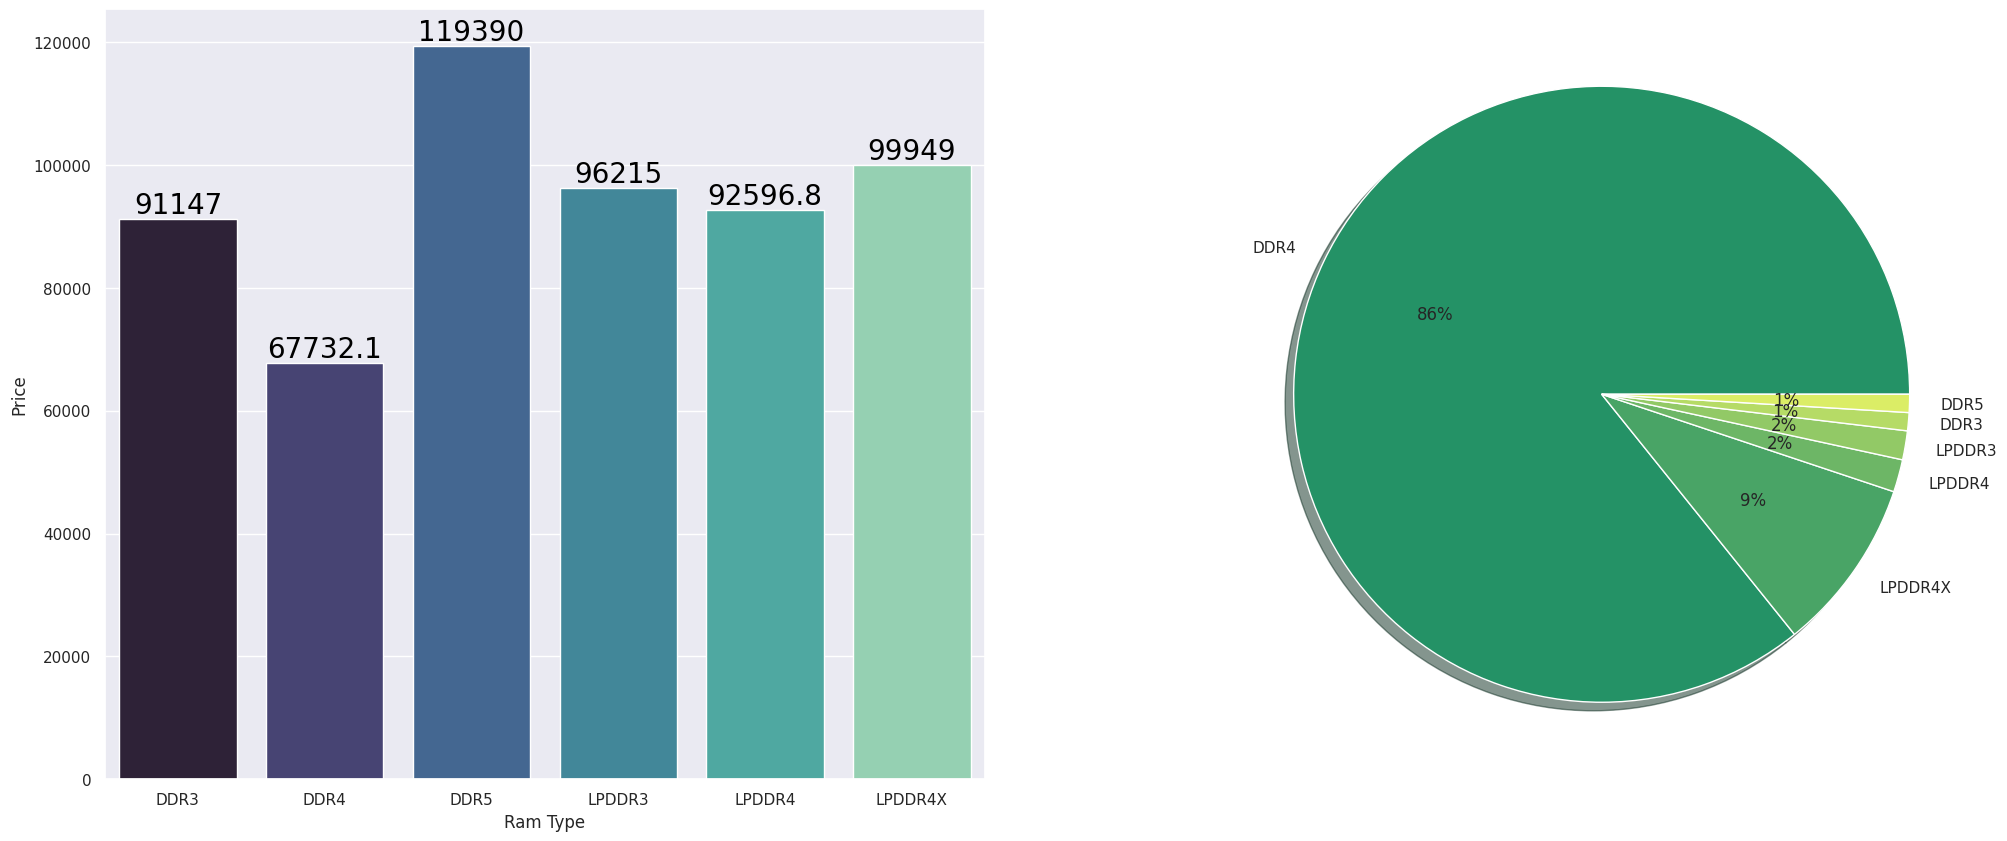

In [ ]:
f,ax=plt.subplots(1,2,figsize=(25,10))
Group_data = df.groupby('ram_type')
sns.barplot(x = Group_data ['Price'].mean().index, y = Group_data['Price'].mean().values,ax= ax[0],  palette = 'mako')
for container in ax[0].containers:
    ax[0].bar_label(container,color='black',size=20)
    ax[0].set_xlabel("Ram Type")
    ax[0].set_ylabel("Price")
palette_color = sns.color_palette('summer')
plt.pie(x = df['ram_type'].value_counts(),labels=df['ram_type'].value_counts().index,autopct='%.0f%%',shadow=True, colors= palette_color)
plt.show()

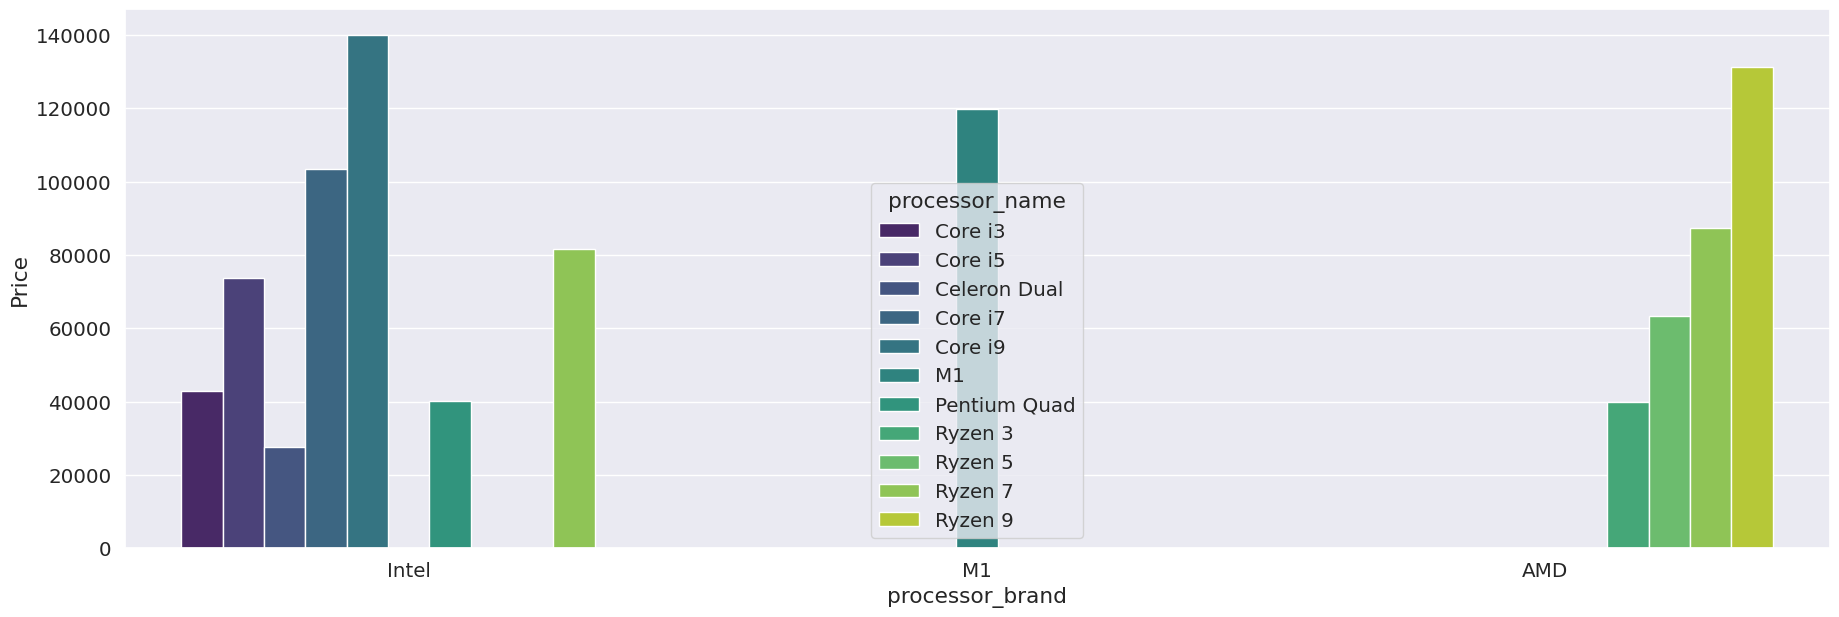

In [ ]:
sns.set_context('notebook', font_scale = 1.3)
plt.figure(figsize=(22, 7))
ax = sns.barplot(x=df['processor_brand'],
                 y=df['Price'],
                 hue = df['processor_name'],
                 palette='viridis',
                 ci = None)
plt.ylabel('Price');

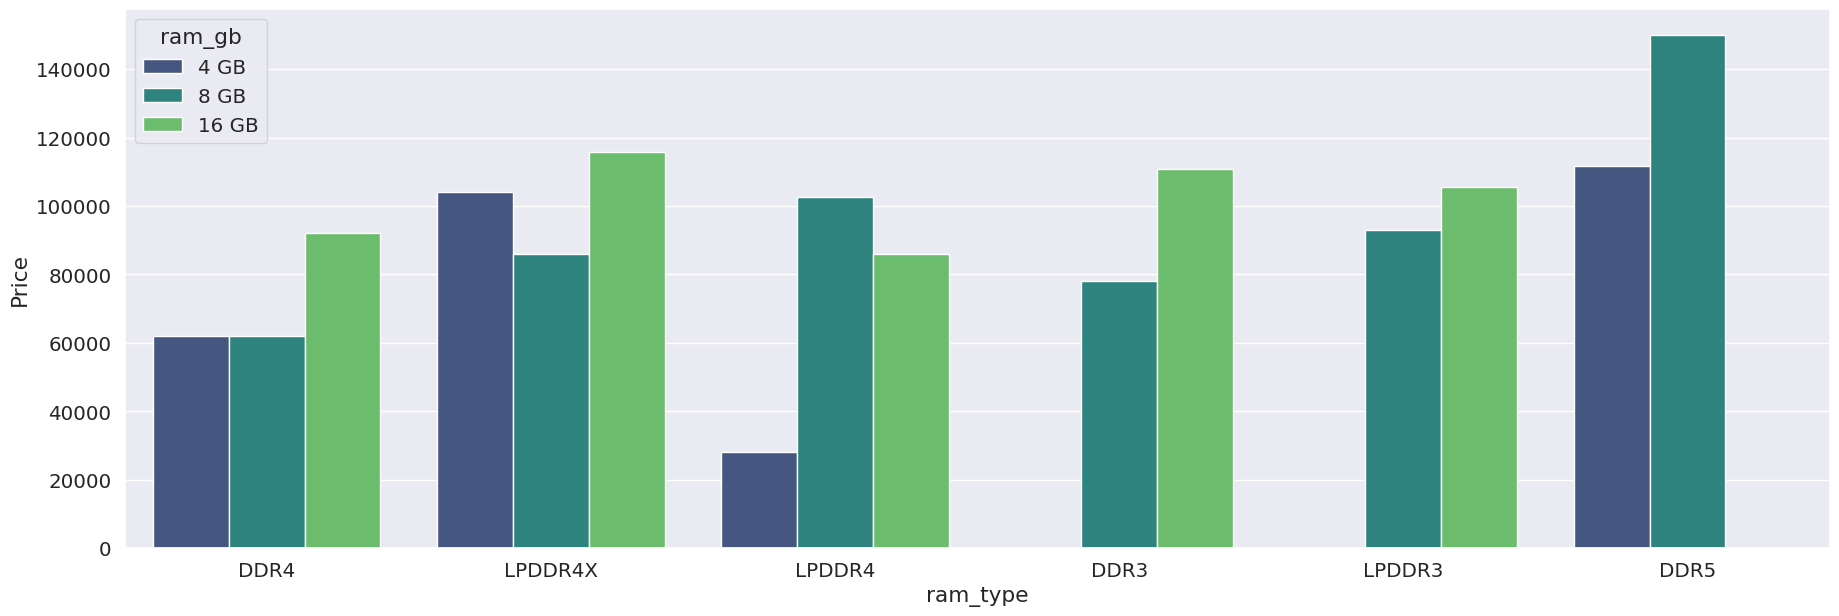

In [ ]:
sns.set_context('notebook', font_scale = 1.3)
plt.figure(figsize=(22, 7))
ax = sns.barplot(x=df['ram_type'],
                 y=df['Price'],
                 hue = df['ram_gb'],
                 palette='viridis',
                 ci = None)
plt.ylabel('Price');

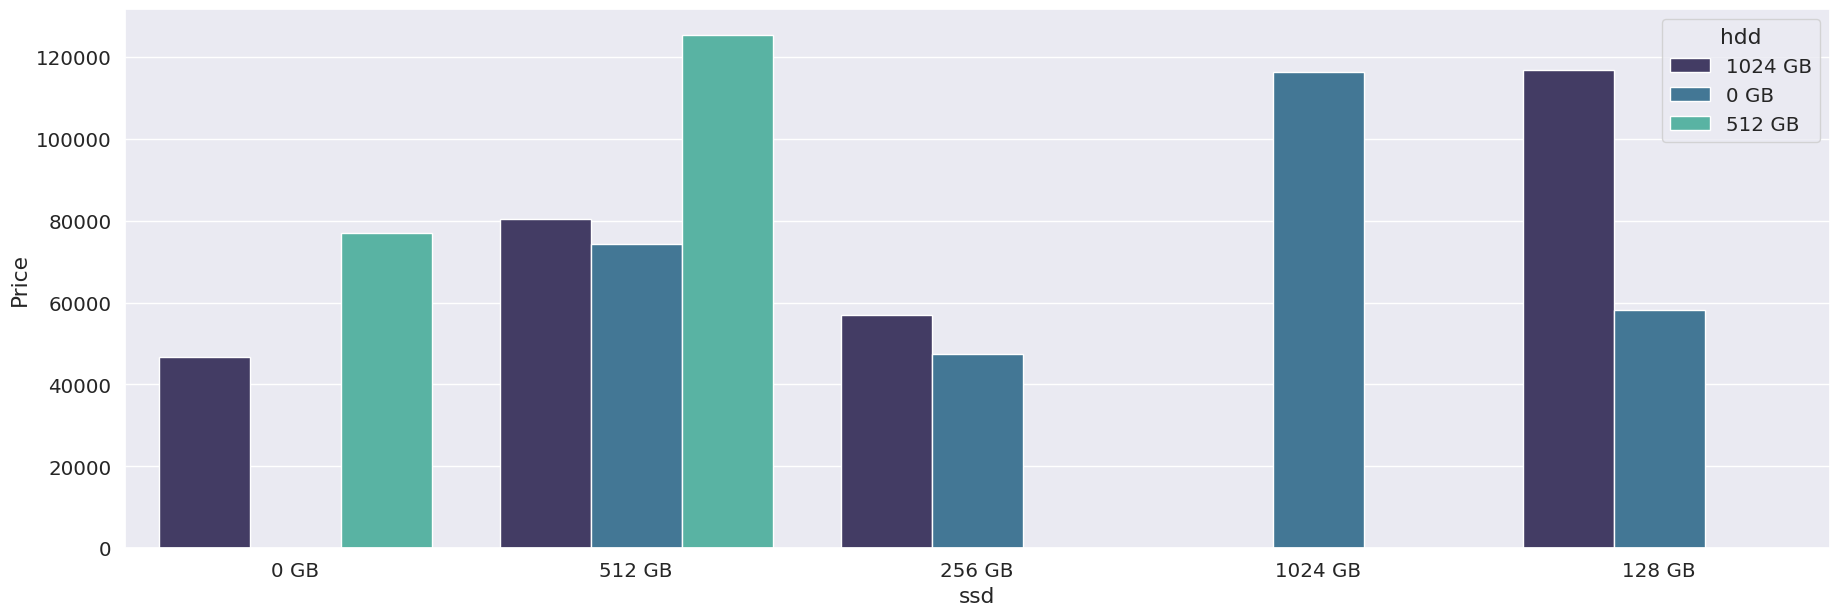

In [ ]:
sns.set_context('notebook', font_scale = 1.3)
plt.figure(figsize=(22, 7))
ax = sns.barplot(x=df['ssd'],
                 y=df['Price'],
                 hue = df['hdd'],
                 palette='mako',
                 ci = None)
plt.ylabel('Price');

### **4. Transformation Pipeline**

In [ ]:
class TransformationPipeline:
    def __init__(self, df):
        self.df = df

    def preprocess(self):
        # 1) identify columns
        cat_cols = self.df.select_dtypes(include='object').columns.tolist()
        num_cols = ['Number of Ratings', 'Number of Reviews']

        # 2) numeric: median impute → standard scale
        num_pipeline = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler",  StandardScaler())
        ])

        # 3) categorical: most_frequent impute → one-hot → scale without centering
        cat_pipeline = Pipeline(steps=[
            ("imputer",        SimpleImputer(strategy="most_frequent")),
            # drop `sparse=`; defaults to sparse_output=True in sklearn ≥1.2
            ("one_hot",        OneHotEncoder(handle_unknown='ignore')),
            ("scale_no_mean",  StandardScaler(with_mean=False))
        ])

        # 4) stitch together, drop anything else
        preprocessor = ColumnTransformer(
            transformers=[
                ("num", num_pipeline, num_cols),
                ("cat", cat_pipeline, cat_cols)
            ],
            remainder='drop'
        )

        return preprocessor


In [ ]:
X = df.drop('Price', axis = 1)
y = df.Price

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state= 1)
X_train.shape, X_test.shape

((474, 18), (53, 18))

In [ ]:
tp = TransformationPipeline(df)
preprocessor = tp.preprocess()

In [ ]:
X_train = preprocessor.fit_transform(X_train)
X_test  = preprocessor.transform(X_test)


In [ ]:
feature_names = preprocessor.get_feature_names_out()

In [ ]:
import pandas as pd
X_df = pd.DataFrame.sparse.from_spmatrix(X_train, columns=feature_names)
print(X_df.columns)
print(X_df.shape)
X_df.head()

Index(['num__Number of Ratings', 'num__Number of Reviews', 'cat__brand_APPLE',
       'cat__brand_ASUS', 'cat__brand_Avita', 'cat__brand_DELL',
       'cat__brand_HP', 'cat__brand_Lenovo', 'cat__brand_MSI',
       'cat__brand_acer', 'cat__processor_brand_AMD',
       'cat__processor_brand_Intel', 'cat__processor_brand_M1',
       'cat__processor_name_Celeron Dual', 'cat__processor_name_Core i3',
       'cat__processor_name_Core i5', 'cat__processor_name_Core i7',
       'cat__processor_name_Core i9', 'cat__processor_name_M1',
       'cat__processor_name_Pentium Quad', 'cat__processor_name_Ryzen 3',
       'cat__processor_name_Ryzen 5', 'cat__processor_name_Ryzen 7',
       'cat__processor_name_Ryzen 9', 'cat__processor_gnrtn_10th',
       'cat__processor_gnrtn_11th', 'cat__processor_gnrtn_12th',
       'cat__processor_gnrtn_7th', 'cat__processor_gnrtn_8th',
       'cat__processor_gnrtn_9th', 'cat__processor_gnrtn_Not Available',
       'cat__ram_gb_16 GB', 'cat__ram_gb_4 GB', 'cat__ram

,num__Number of Ratings,num__Number of Reviews,cat__brand_APPLE,cat__brand_ASUS,cat__brand_Avita,cat__brand_DELL,cat__brand_HP,cat__brand_Lenovo,cat__brand_MSI,cat__brand_acer,...,cat__warranty_No warranty,cat__Touchscreen_No,cat__Touchscreen_Yes,cat__msoffice_No,cat__msoffice_Yes,cat__rating_1 star,cat__rating_2 stars,cat__rating_3 stars,cat__rating_4 stars,cat__rating_5 stars
0,-0.388028,-0.330997,0,2.128151,0,0,0,0,0,0,...,0,2.802184,0,0,2.093394,0,0,0,2.030616,0
1,-0.654365,-0.663397,0,2.128151,0,0,0,0,0,0,...,0,2.802184,0,2.093394,0,0,0,2.007898,0,0
2,-0.654365,-0.663397,0,0,0,0,2.870409,0,0,0,...,0,0,2.802184,0,2.093394,0,0,2.007898,0,0
3,0.867564,0.333802,0,0,0,0,2.870409,0,0,0,...,0,2.802184,0,0,2.093394,0,0,0,2.030616,0
4,-0.654365,-0.663397,0,0,0,2.488266,0,0,0,0,...,0,2.802184,0,2.093394,0,0,0,2.007898,0,0


### **5. Modelling**

In [ ]:
models = {
    'ridge' : Ridge(),
    'xgboost' : XGBRegressor(),
    'catboost' : CatBoostRegressor(verbose=0),
    'lightgbm' : LGBMRegressor(),
    'gradient boosting' : GradientBoostingRegressor(),
    'lasso' : Lasso(),
    'random forest' : RandomForestRegressor(),
    'support vector': SVR(),
    'ada boost regressor': AdaBoostRegressor()
}

In [ ]:
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f'{name} trained')

ridge trained
xgboost trained
catboost trained
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 474, number of used features: 46
[LightGBM] [Info] Start training from score 72042.677215
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

In [ ]:
amodel = tf.keras.Sequential()

amodel.add(tf.keras.layers.Dense(79))
amodel.add(tf.keras.layers.Dense(200))
amodel.add(tf.keras.layers.Dense(200))
amodel.add(tf.keras.layers.Dense(200))
amodel.add(tf.keras.layers.Dense(1))

amodel.compile(
    loss = 'mse',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

amodel.fit(X_train.toarray(), y_train, validation_data=(X_test.toarray(), y_test), epochs=50)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 6306603520.0000 - rmse: 79402.9766 - val_loss: 6227245056.0000 - val_rmse: 78912.8906
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5810419712.0000 - rmse: 76204.6094 - val_loss: 5395881984.0000 - val_rmse: 73456.6641
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4403466752.0000 - rmse: 66257.4609 - val_loss: 1647788928.0000 - val_rmse: 40592.9648
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1238820096.0000 - rmse: 35049.3359 - val_loss: 764064768.0000 - val_rmse: 27641.7207
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 742249600.0000 - rmse: 27228.9922 - val_loss: 610058496.0000 - val_rmse: 24699.3633
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 535857376.0000 - rmse: 23133.9102 - val_loss: 448629536.0000 - val_rmse: 21180.8770
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 460746752.0000 - rmse: 21453.5020 - val_loss: 348859616.0000 - val_rmse: 18677.783

In [ ]:
RMSE_ann = amodel.evaluate(X_test.toarray(), y_test)[1]
RMSE_ann

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 117794968.0000 - rmse: 10828.1797


11350.4306640625

In [ ]:
results = {}
kf = KFold(n_splits= 10)

for name, model in models.items():
    result = np.mean(np.sqrt(-cross_val_score(model, X_train, y_train, scoring = 'neg_mean_squared_error', cv= kf)))
    results[name] = result

results['ANN'] = RMSE_ann

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 148
[LightGBM] [Info] Number of data points in the train set: 426, number of used features: 44
[LightGBM] [Info] Start training from score 71547.769953
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [ ]:
for name, result in results.items():
    print(f"{name} : {round(result, 3)}")

ridge : 13953.289
xgboost : 13883.845
catboost : 13045.925
lightgbm : 14243.84
gradient boosting : 13553.575
lasso : 14114.202
random forest : 14362.44
support vector : 30028.626
ada boost regressor : 19232.377
ANN : 11350.431


In [ ]:
results_df = pd.DataFrame(results, index=range(0,1)).T.rename(columns={0: 'RMSE'}).sort_values('RMSE', ascending=False)
results_df.T

,support vector,ada boost regressor,random forest,lightgbm,lasso,ridge,xgboost,gradient boosting,catboost,ANN
RMSE,30028.626155,19232.377428,14362.440136,14243.839952,14114.202136,13953.289282,13883.845002,13553.575067,13045.9248,11350.430664


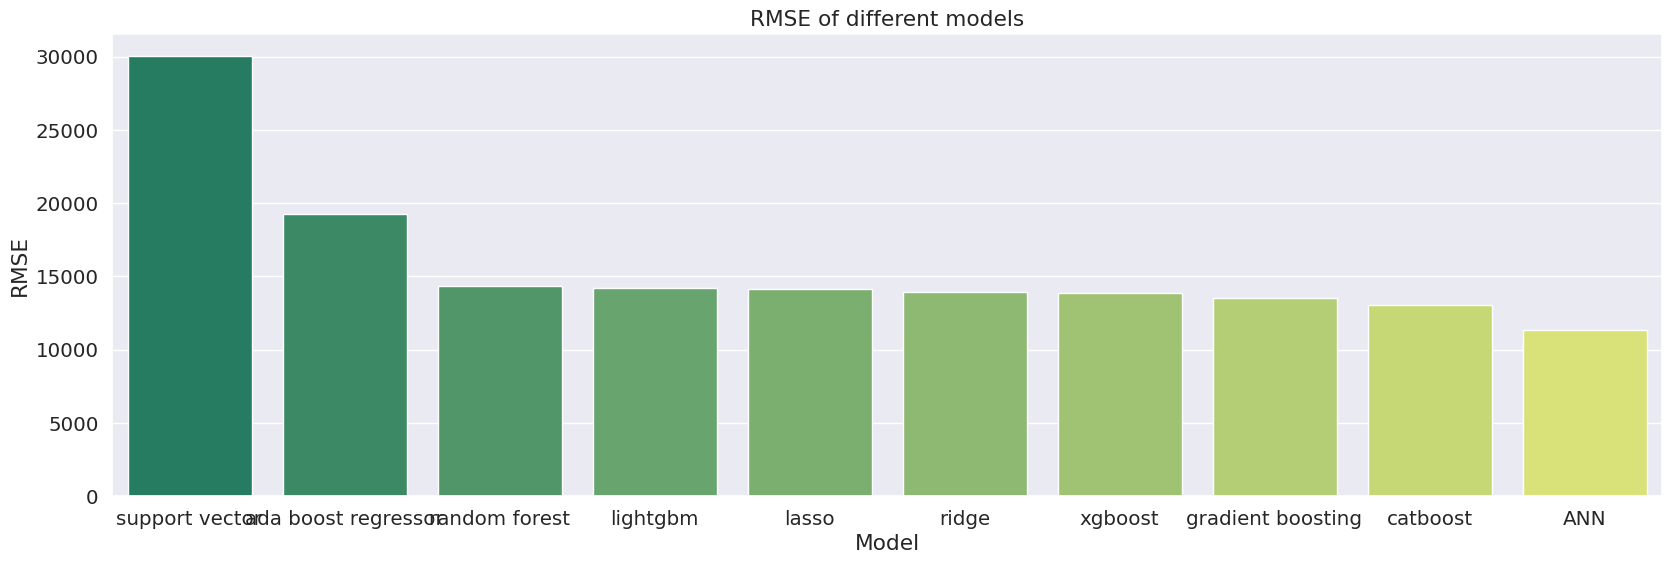

In [ ]:
plt.figure(figsize = (20, 6))
sns.barplot(x= results_df.index, y = results_df['RMSE'], palette = 'summer')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE of different models');

In [ ]:
final_predictions = (
    0.50 * model.predict(X_test.toarray()).reshape(53) +
    0.20 * models['catboost'].predict(X_test) +
    0.15 * models['gradient boosting'].predict(X_test) +
    0.10 * models['random forest'].predict(X_test) +
    0.05 * models['xgboost'].predict(X_test)
)

In [ ]:
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, final_predictions))}')
print(f'R-square: {r2_score(y_test, final_predictions)}')

RMSE: 12721.470994907015
R-square: 0.8041362813684245


### **6. Evaluation**

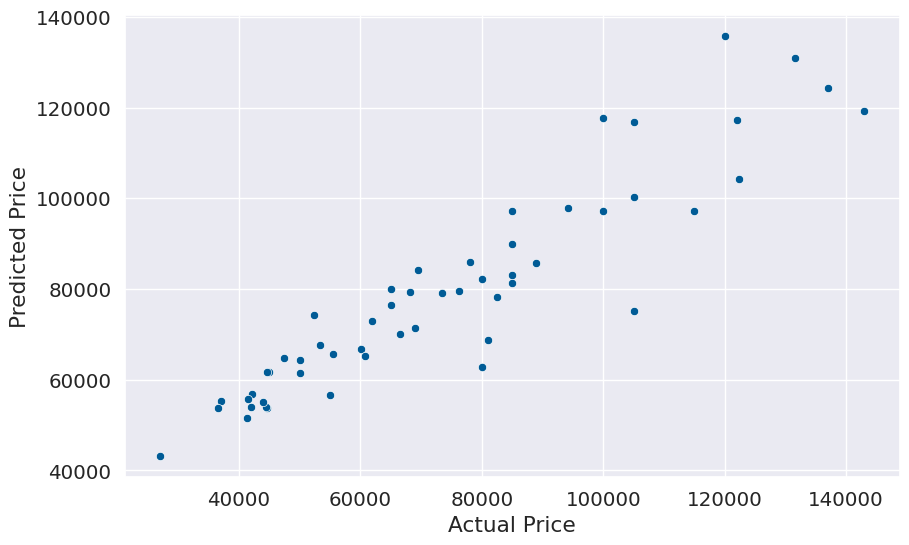

In [ ]:
plt.figure(figsize= (10, 6))
sns.scatterplot(x= y_test, y= final_predictions, color= '#005b96')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

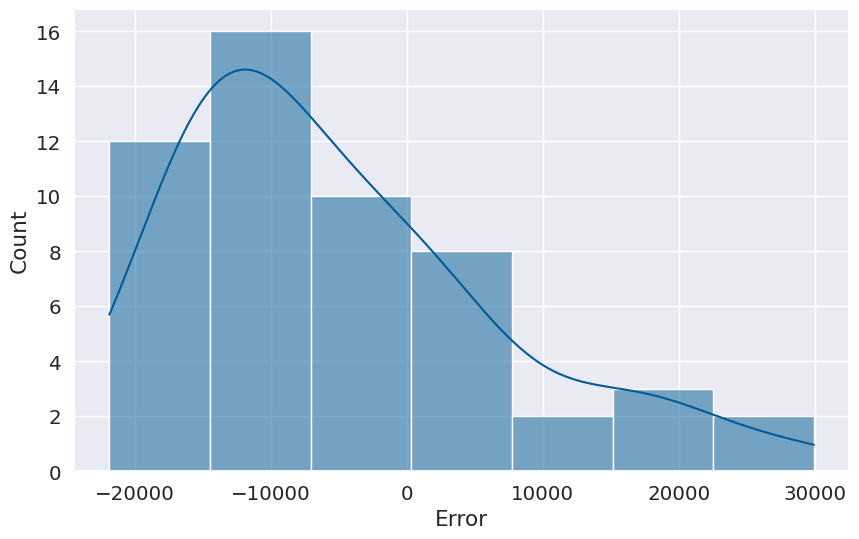

In [ ]:
# Distribution of error
plt.figure(figsize = (10, 6))
sns.histplot(y_test - final_predictions, color = '#005b96', kde= True)
plt.xlabel('Error');

In [ ]:
os.makedirs("model", exist_ok=True)

joblib.dump(preprocessor, "model/preprocessor.joblib")
amodel.save("model/laptop_price_model.h5")

RAW_COLS = X_df.columns.tolist()
json.dump({"raw_cols": RAW_COLS},
          open("model/meta.json", "w", encoding="utf-8"), indent=2)